# Cliffwalk gridworld with SARSA and Q-learning

In [1]:
import agents
import gridworld
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


from numba import njit
from copy import deepcopy
from itertools import product

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
n_rows = 4
n_cols = 12

In [49]:
movements = np.array([
    [0, 1], # right
    [0, -1], # left
    [1, 0], # down,
    [-1, 0], # up
    # [0, 0], # nothing
])
n_actions = len(movements)

name_movements = ["right", "left", "down", "up"]
# name_movements = ["right", "left", "down", "up", "nothing"]

map_movements = {n: move for n, move in enumerate(name_movements)}

In [69]:
start_ix = 36
end_ix = 47
reward_goal =  100
G = gridworld.CliffGridworld(start_ix, end_ix, n_rows, n_cols, reward_goal)

In [129]:
n_steps = 8_000
epsilon = 0.1
alpha = 0.5
gamma = 1.0

seed = 314
hist_sarsa, Q_sarsa = agents.run_agent(
    start_ix, G, n_actions, n_steps, epsilon, alpha, gamma, movements,
    agents.sarsa_step_and_update,
    seed=seed
)

hist_qlearn, Q_qlearn = agents.run_agent(
    start_ix, G, n_actions, n_steps, epsilon, alpha, gamma, movements,
    agents.qlearning_step_and_update,
    seed=314159
)

hist_expected_sarsa, Q_expected_sarsa = agents.run_agent(
    start_ix, G, n_actions, n_steps, epsilon, alpha, gamma, movements,
    agents.expected_sarsa_step_and_update
)

hist = {
    "sarsa": deepcopy(hist_sarsa),
    "q": deepcopy(hist_qlearn),
    "expected_sarsa": deepcopy(hist_expected_sarsa)
}

del hist_qlearn, hist_sarsa, hist_expected_sarsa

In [133]:
hist["sarsa"]["reward"][-500:].mean()

0.422

In [134]:
hist["q"]["reward"][-500:].mean()

2.878

In [135]:
hist["expected_sarsa"]["reward"][-500:].mean()

4.458

In [136]:
markers = {
    "down": "v",
    "up": "^",
    "right": ">",
    "left": "<",
    "nothing": "o"
}

In [137]:
def plot_agent_run(
    ax, hist_agent, run, gridworld, reward_goal,
    c_line="black", c_arrow="crimson", show_step=False
):
    ix_goal = np.where(hist_agent["reward"] == reward_goal)[0]
    pos_hist = np.c_[hist_agent["ix"] % gridworld.n_cols, hist_agent["ix"] // gridworld.n_cols]
    iinit = ix_goal[run] + 1
    iend = ix_goal[run + 1] + 1
    
    subhist_action = hist_agent["action"][iinit:iend]
    subhist_action = [name_movements[a] for a in subhist_action]
    subhist_action = [markers[action] for action in subhist_action]
    
    subhist_pos = pos_hist[iinit:iend]
    
    ax.plot(*subhist_pos.T, c=c_line, linestyle="--")
    
    for i, ((x,y), m) in enumerate(zip(subhist_pos, subhist_action)):
        ax.scatter(x, y, marker=m, zorder=3, s=50, c=c_arrow)
        if show_step:
            ax.text(x, y, i, verticalalignment="bottom", horizontalalignment="left")


def plot_gridworld_board(ax, gridworld):
    xticks = np.arange(gridworld.n_cols)
    yticks = np.arange(gridworld.n_rows)
    ax.set(
        xticks=xticks + 0.5,
        yticks=yticks + 0.5,
        xticklabels="",
        yticklabels="",
    )
    ax.set_xticks(xticks, labels=xticks, minor=True)
    ax.set_yticks(yticks, labels=yticks, minor=True)
    
    ax.set_ylim(-0.5, gridworld.n_rows - 0.5)
    ax.set_xlim(-0.5, gridworld.n_cols - 0.5)
    ax.invert_yaxis()
    
    for i, (r, c) in enumerate(product(range(gridworld.n_rows), range(gridworld.n_cols))):
        ax.text(c, r, i, c="tab:gray", zorder=0, fontsize=6)
    
    ax.grid(alpha=0.3)

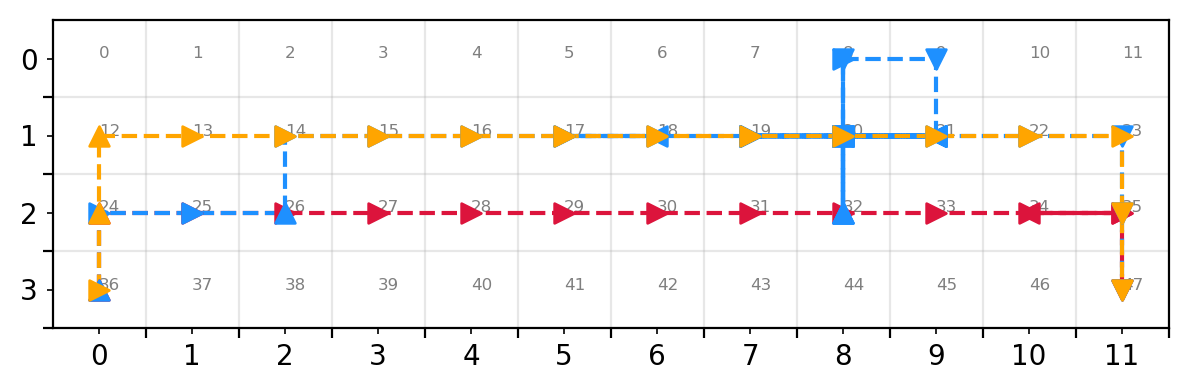

In [146]:
fig, ax = plt.subplots(figsize=(n_cols * 0.6, n_rows * 0.5))

plot_gridworld_board(ax, G)

plot_agent_run(ax, hist["q"], -3, G, reward_goal, c_line="crimson")
plot_agent_run(ax, hist["sarsa"], -3, G, reward_goal, c_line="dodgerblue", c_arrow="dodgerblue")
plot_agent_run(ax, hist["expected_sarsa"], -3, G, reward_goal, c_line="orange", c_arrow="orange")

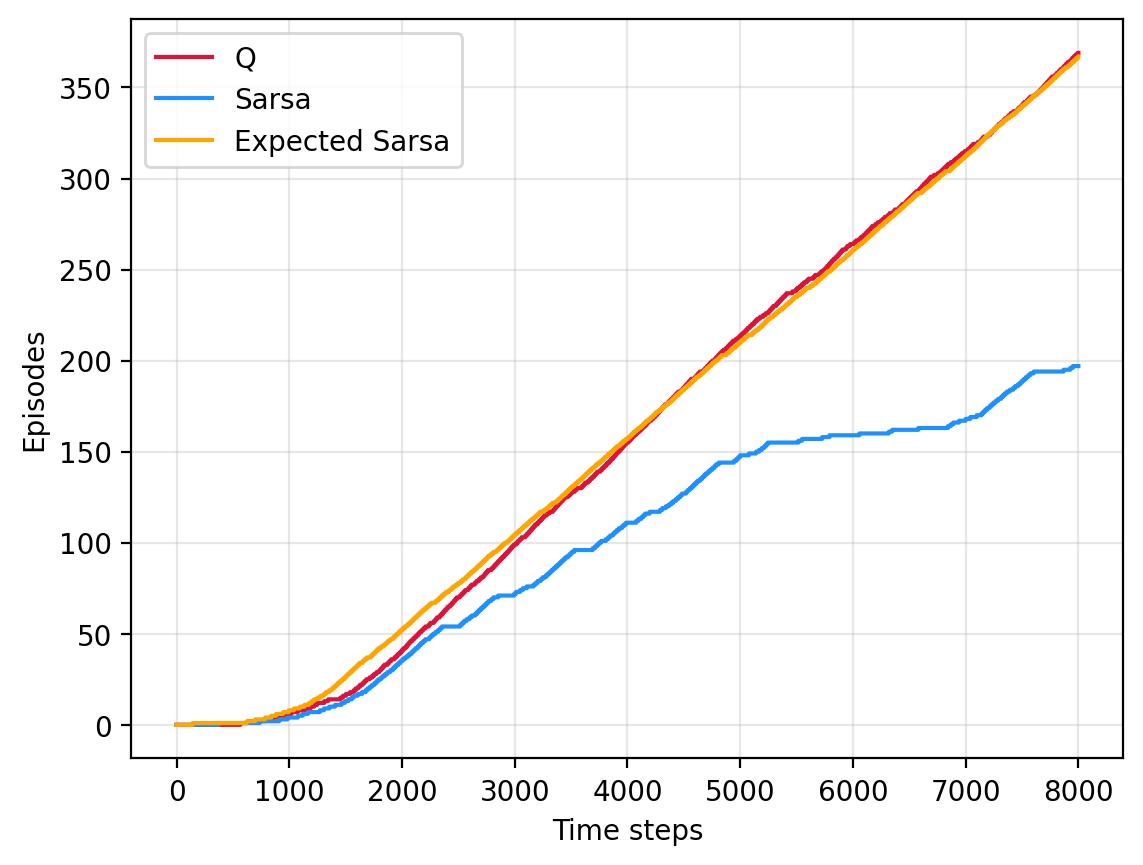

In [149]:
plt.plot((hist["q"]["reward"] == reward_goal).cumsum(), c="crimson", label="Q")
plt.plot((hist["sarsa"]["reward"] == reward_goal).cumsum(), c="dodgerblue", label="Sarsa")
plt.plot((hist["expected_sarsa"]["reward"] == reward_goal).cumsum(), c="orange", label="Expected Sarsa")

plt.legend()
plt.grid(alpha=0.3)
plt.xlabel("Time steps")
plt.ylabel("Episodes");

In [130]:
np.array([markers[map_movements[a]] for a in Q_qlearn.argmax(axis=1)]).reshape(G.n_rows, G.n_cols)

array([['<', '^', '>', '>', '>', 'v', 'v', '>', '>', '>', 'v', 'v'],
       ['v', 'v', 'v', '>', 'v', '>', 'v', 'v', 'v', 'v', 'v', 'v'],
       ['>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', 'v'],
       ['^', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '^']],
      dtype='<U1')

In [131]:
np.array([markers[map_movements[a]] for a in Q_sarsa.argmax(axis=1)]).reshape(G.n_rows, G.n_cols)

array([['>', 'v', '>', 'v', '<', '>', 'v', 'v', '>', 'v', '>', 'v'],
       ['<', '>', '>', '>', '>', '>', '>', '>', '^', '<', '>', 'v'],
       ['>', '>', '^', '^', '<', '^', '^', '^', '^', '^', '^', 'v'],
       ['^', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', 'v']],
      dtype='<U1')

In [132]:
np.array([markers[map_movements[a]] for a in Q_expected_sarsa.argmax(axis=1)]).reshape(G.n_rows, G.n_cols)

array([['v', '>', '>', 'v', 'v', '>', '>', '>', 'v', '<', 'v', 'v'],
       ['>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', 'v'],
       ['^', '^', '^', '^', '^', '^', '^', '<', '^', '^', '>', 'v'],
       ['^', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>']],
      dtype='<U1')

## Multiple runs

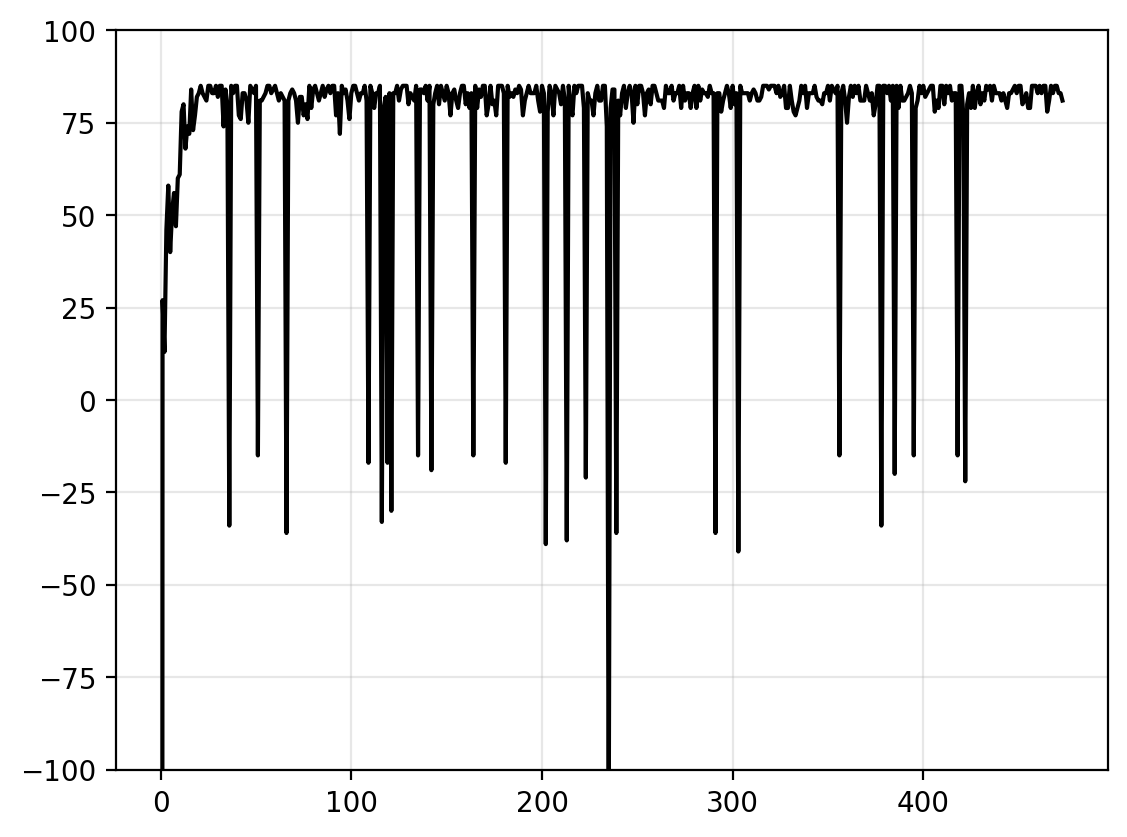

In [124]:
agent = "expected_sarsa"

ix_goal = np.where(hist[agent]["reward"] == reward_goal)[0]
pos_hist = np.c_[hist[agent]["ix"] % n_cols, hist[agent]["ix"] // n_cols]
distance_hist = np.abs(pos_hist - G.get_pos(end_ix)).sum(axis=1)
len(ix_goal)

sum_rewards = []
for ix_start, ix_end in zip(ix_goal[:-1], ix_goal[1:]):
    r = hist[agent]["reward"][ix_start + 1:ix_end+1].sum()
    sum_rewards.append(r)
sum_rewards = np.array(sum_rewards)

plt.plot(sum_rewards, c="black")
plt.ylim(bottom=-100, top=100)
plt.grid(alpha=0.3)